In [119]:
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Embedding, Masking, Lambda, Layer
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

from importnb import Notebook
with Notebook(): 
    import Utilities

In [125]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [4]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
sentence_embeddings = model.encode(sentences)

In [14]:
# Load data 
news_path = Path("../Datasets/data/financial_headlines_20061020-20131119.pkl")
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)


In [32]:
n = len(data.index.drop_duplicates())

path = Path("../Input Data/all_reuters_news_embedded_bert_base_nli_mean")
if os.path.exists(path)
    x = np.load(path)
    embed_dim = x.shape[-1]
    max_nbr_titles = x.shape[-2]
else:
    texts = []
    for i,date in enumerate(data.index.drop_duplicates()): 
        if i % 100: 
            print("{} % ...".format(round(100 * i / len(data.index.drop_duplicates()),3)),end='\r')
        temp_titles = []
        for title in data.loc[date].values:
            temp_titles.append(title[0])
        texts.append(model.encode(temp_titles))
    print("100 % ...")
    max_nbr_titles = max([len(text) for text in texts])
    embed_dim = texts[0][0].shape[0]
    x = np.zeros((n,max_nbr_titles,embed_dim))
    # Include embeddings in matrix and pad with (tensors) of zeros. 
    for i,titles in enumerate(texts): 
        for j,title in enumerate(titles): 
            x[i,j] = title
    np.save(path,x)

In [148]:
config = {
    'embed_dim': embed_dim,    # Dimensions to use for the word embedding
    'max_len': max_nbr_titles,
    'lookback': 1,       # How far back to collect data in the recurrent layer (days)
    'delay': 1,          # How far ahead to predict data (days)
    'p': 1,              # Order of the AR-part of the model
    'd': 1,              # Integrated order
    'q': 1,              # Included moving average terms 
    'train_part' : 0.8,  # Part of data to be used for training
    'val_part' : 0.1,    # Part of data to be used for validation
    'test_part' : 0.1,   # Part of data to be used for testing
    'series': '1 YEAR',   # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [58]:
x.shape

(2582, 104, 768)

In [66]:
y = Utilities.load_regression_labels(config)

Loaded previously constructed labels. 


In [72]:
# Need to remove some rows from the word embedding-matrix,
# these numbers are specified in Utilities.fit_all_models()
rm_start_rows = max(config['lookback'],5) + 1
rm_end_rows = config['delay']
x = x[rm_start_rows : -rm_end_rows]

In [110]:
(x_train, y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y,test_part = config['test_part'])
print("Shape of x_train:",x_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (2317, 104, 768)
Shape of y_train: (2317,)
Shape of x_test: (258, 104, 768)
Shape of y_test: (258,)


In [99]:
# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero

def merge_output_shape(input_shape):
    return (input_shape[0], input_shape[2])

In [229]:
model = Sequential()
model.add(Lambda(merge_embeddings, input_shape=x_train.shape[1:], output_shape=merge_output_shape))
          
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 768)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [232]:
epochs = 100

h = model.fit(x_train, y_train, epochs = epochs, validation_split=config['val_part'],verbose=0)

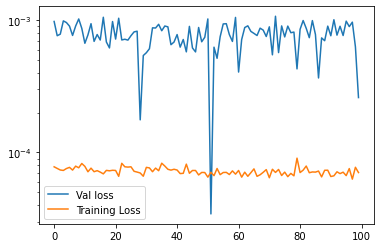

Model test score: 0.0004279944060240374
Zero test score: 4.023111572553152e-05


In [233]:
plt.plot(h.history['val_loss'], label='Val loss')
plt.plot(h.history['loss'], label='Training Loss')
plt.yscale('log')
plt.legend()
plt.show() 
score = model.evaluate(x_test, y_test, verbose=0)
zero_score = np.dot(y_test, y_test) / len(y_test)
print("Model test score:",score)
print("Zero test score:",zero_score)

In [226]:
test_sents = [
    "Veberöd Mushroom Factory claims quality award."
    "The economy is dead.",
    "The American President has committed suicide.", 
    "Worst crisis in 1000 years. ",
    "Corona virus stopps all production in 100 countries.",
    "BEST DAY EVER!",
    "Amazing comeback from american stocks",
    "Truly awesome day on the market today."
]
enc_sents = sbert_model.encode(test_sents)
x_inp = np.zeros((1, config['max_len'], config['embed_dim'])) 
for i,row in enumerate(enc_sents):
    x_inp[0,i] = row


In [227]:
y_pred = model.predict(x_inp)

In [228]:
y_pred

array([[-0.00031726]], dtype=float32)

array([[[ 0.05641313,  0.43250403,  1.2209636 , ..., -0.08560896,
          0.06196363, -0.46169922],
        [ 0.20730712,  0.60533875, -0.13538317, ..., -0.50943702,
          0.40553239, -0.00730546],
        [-0.35821676,  0.95740557,  0.50074011, ..., -1.16877079,
          0.9151963 ,  0.11431099],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])